In [2]:
#import necessary packages

import pathlib as Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models
#from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence 
import torch.nn.functional as F
import os
import pydicom as dicom
import matplotlib.patches as mpatches
import matplotlib.animation as animation
import matplotlib.image as img
import zipfile
import cv2
#from google.colab.patches import cv2_imshow
from tqdm import tqdm
import time
from PIL import Image
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [24]:
scan_dir = 'data/images'
mask_dir = 'mask'

scan_list = os.listdir(scan_dir)
mask_list = os.listdir(mask_dir)
scan_list = scan_list

img_list = []

for each in scan_list:
    if not each.startswith('.'):
        img_list.append(each)
img_list = sorted(img_list)

num_patient = len(img_list)

print(img_list)
print(num_patient)

['images_01', 'images_02', 'images_03', 'images_04', 'images_05', 'images_06', 'images_07', 'images_08', 'images_09', 'images_10', 'images_11', 'images_12', 'images_13', 'images_14', 'images_15', 'images_16', 'images_17', 'images_18', 'images_19', 'images_20', 'images_21', 'images_22', 'images_23']
23


In [4]:
classes = {
    0 : 'background',
    1 : 'pelvic bone',
    2 : 'femur',
    3 : 'low spine bone',
    4 : 'mid spine bone',
    5 : 'high spine bone'
}

In [5]:
# functtion that shows 6 tissues ground truth image
def mask2img(mask):
    palette = {
        0: (0, 0, 0),
        1: (255, 0, 0),
        2: (0, 255, 0),
        3: (0, 0, 255),
        4: (0, 255, 255),
        5: (255, 255, 0)
    }
    palette_norm = {
        0: (0, 0, 0),
        1: (1, 0, 0),
        2: (0, 1, 0),
        3: (0, 0, 1),
        4: (0, 1, 1),
        5: (1, 1, 0)
    }
    rows = mask.shape[0]
    cols = mask.shape[1]
    image = np.zeros((rows, cols, 3), dtype=np.uint8)
    for j in range(rows):
        for i in range(cols):
            image[j, i] = palette[int(mask[j, i])]

    patch0 = mpatches.Patch(color=palette_norm[0], label=classes[0])
    patch1 = mpatches.Patch(color=palette_norm[1], label=classes[1])
    patch2 = mpatches.Patch(color=palette_norm[2], label=classes[2])
    patch3 = mpatches.Patch(color=palette_norm[3], label=classes[3])
    patch4 = mpatches.Patch(color=palette_norm[4], label=classes[4])

    handles = [patch0, patch1, patch2, patch3, patch4]
    return image, handles

In [6]:
def show_pair(scan_num=5, slice_num=27):
    image = 'images_' + str(scan_num)
    mask = 'images_' + str(scan_num) + '_mask.nii'

    image_dir = os.path.join(scan_dir, image)
    mask = os.path.join(mask_dir, mask)
    scan = os.path.join(image_dir, sorted(os.listdir(image_dir))[slice_num-1])

    test_img = dicom.read_file(scan)
    test_img = test_img.pixel_array

    mask_img = nib.load(mask).get_fdata()
    mask_img = np.rot90(mask_img, 1)
    mask_img = cv2.flip(mask_img, 0)
    
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(test_img, cmap=plt.cm.bone)  # set the color map to bone
    mask_image, handles = mask2img(mask_img[:,:,slice_num-1])
    ax[0].set_title('2D Slice')
    print(mask_image.shape)
    ax[1].imshow(mask_image)
    ax[1].legend(handles=handles, bbox_to_anchor=(1.85, 1))
    ax[1].set_title('Ground Truth Segmentation Mask')
    fig.savefig('figs/test_scan_mask_pair.jpg')
    fig.suptitle('Side-by-Side Comparsion Between 2D Slice and Mask')
    print(np.unique(mask_img[:,:,slice_num-1]))

(384, 384, 3)
[0. 1. 2. 3. 4. 5.]


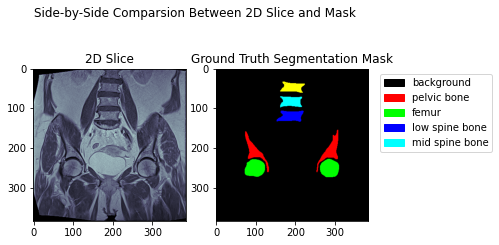

In [7]:
show_pair()

In [8]:
def create_gif():
    dir = 'data/images/images_1'
    length = len(os.listdir(dir))
    dir_list = os.listdir(dir)

    for i in range(length):
        scan_dir = dir_list[i]
        scan = os.path.join(dir, os.listdir(dir)[i])
        print(scan)
        test_img = dicom.read_file(scan)
        test_img = test_img.pixel_array

        fig,ax = plt.subplots()
        ax.imshow(test_img, cmap=plt.cm.bone)
        name = 'gif'+str(i)
        fig.savefig('figs/'+name)

## Function to stack the input 2d slices and save it into another directory

In [26]:
class config:
    ORIG_HEIGHT = 384
    ORIG_WIDTH = 384

In [38]:
def stack_slices(patient_index, scan_dir=scan_dir, slice_list=img_list):
    new_dir = 'data/images_3d/'
    new_file = 'images_'
    if patient_index < 10:
        name = '0' + str(patient_index)
    else:
        name = str(patient_index)
    new_file_path = new_dir + new_file + name + '.npy'

    patient_index = img_list[patient_index-1]
    patient_dir = os.path.join(scan_dir, patient_index)
    slice_len = len(os.listdir(patient_dir))
    slice_list = sorted(os.listdir(patient_dir))
    empty_3d_list = np.zeros((config.ORIG_HEIGHT, config.ORIG_WIDTH, slice_len))
    for i in range(slice_len):
        slice = os.path.join(patient_dir, slice_list[i])
        read = dicom.read_file(slice).pixel_array
        empty_3d_list[:, :, i] = read
    #plt.imshow(empty_3d_list[:,:,15])
    np.save(new_file_path, empty_3d_list)
    return empty_3d_list

# This will create new directory with stacked 2D scans for each patient
# for i in range(1, num_patient+1):
#     stack_slices(patient_index=i)

(384, 384, 47)


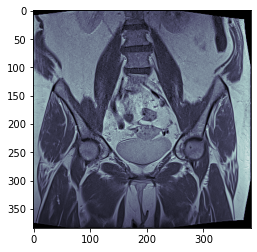

In [59]:
dir = 'mask/images_9_mask.nii'
dir2 = 'data/images_3d/images_09.npy'
print(nib.load(dir).get_fdata().shape)
plt.imshow(np.load(dir2)[:,:,25], cmap=plt.cm.bone)

images_09_mask.nii
(384, 384, 39)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
0.0
mask/multiclass_mask_final/images_09_mask.nii
0 :  [0.]
1 :  [0.]
2 :  [0.]
3 :  [0.]
4 :  [0.]
5 :  [0. 2.]
6 :  [0. 2.]
7 :  [0. 2.]
8 :  [0. 2.]
9 :  [0. 2.]
10 :  [0. 2.]
11 :  [0. 2.]
12 :  [0. 1. 2.]
13 :  [0. 1. 2.]
14 :  [0. 1. 2.]
15 :  [0. 1. 2. 3.]
16 :  [0. 1. 2. 3.]
17 :  [0. 1. 2. 3. 4.]
18 :  [0. 1. 2. 3. 4.]
19 :  [0. 1. 2. 3. 4.]
20 :  [0. 1. 2. 3. 4.]
21 :  [0. 1. 2. 3. 4.]
22 :  [0. 1. 2. 3. 4.]
23 :  [0. 2. 3. 4.]
24 :  [0. 2. 4.]
25 :  [0. 2. 4.]
26 :  [0. 2. 4.]
27 :  [0. 2. 4.]
28 :  [0. 2. 4.]
29 :  [0. 2. 4.]
30 :  [0. 2. 4.]
31 :  [0.]
32 :  [0.]
33 :  [0.]
34 :  [0.]
35 :  [0.]
36 :  [0.]
37 :  [0.]
38 :  [0.]


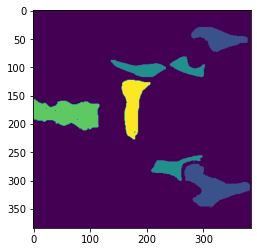

In [50]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2

dir = 'mask/multiclass_mask_final'
scan_name = sorted(os.listdir(dir))[8]
print(scan_name)
scan_temp = nib.load(os.path.join(dir, scan_name))
scan = scan_temp.get_fdata()

plt.imshow(scan[:,:,19])
print(scan.shape)
where5 = np.where(scan==5)
print(where5)
scan[where5] = 0
print(scan[296, 383, 19])
#print(np.unique(scan[:,:,19]))

new_name = os.path.join(dir, scan_name)
print(new_name)

final_mask = nib.Nifti1Image(scan, scan_temp.affine)
nib.save(final_mask, new_name)

for i in range(scan.shape[2]):
    unique = np.unique(scan[:,:,i])
    print(i, ": ", unique)



In [105]:
import os
import tifffile
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import cv2
from PIL import Image

dir = 'mask/femur_binary_mask/images_05_mask.npy'
scan_3d = np.load(dir)
new_dir = 'mask/patient05'
depth = scan_3d.shape[2]
array = []

for i in range(depth):
    slice_2d = scan_3d[:,:,i]
    slice_2d = np.rot90(slice_2d, 3)
    slice_2d = np.flip(slice_2d, 1)
    slice_2d = np.asarray(slice_2d)*255
    array.append(slice_2d)

    if i < 9:
        new_name = 'slice0' + str(i+1) + 'jpg'
    new_name = 'slice' + str(i+1) + '.jpg'
    img = Image.fromarray(slice_2d)
    img = img.convert('RGB')
    new_name = os.path.join(new_dir, new_name)
    img.save(new_name)

In [113]:
array2= np.array(array)
print(array2.shape)
tifffile.imwrite('mask/patient05/patient5_femur.npy', array2)
img = tifffile.imread('mask/patient05/patient5_femur.npy')
print(img.shape)


(45, 384, 384)
(45, 384, 384)


In [53]:
from skimage.io import imread

img = imread('mask/patient05/patient5_femur.tif')
img = img
print(img[25, 248,54])
print(img.shape)

0.0
(45, 384, 384)


In [54]:
pip install napari

Note: you may need to restart the kernel to use updated packages.


In [55]:
import napari


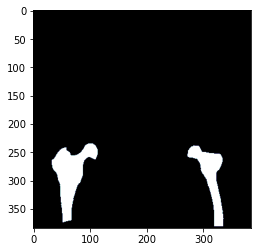

In [61]:
#maximum projections
import numpy as np
import matplotlib.pyplot as plt
max_z = np.max(img, axis=0)
plt.imshow(img[30,:,:], cmap=plt.cm.bone)
plt.show()

In [33]:
import napari

napari.gui_qt()
%gui qt

In [44]:
viewer = napari.Viewer()
viewer.add_image(img)

<Image layer 'img' at 0x7fb1be9bbaf0>

<Image layer 'img' at 0x7fb1ba752bb0>

(840, 1120, 3)


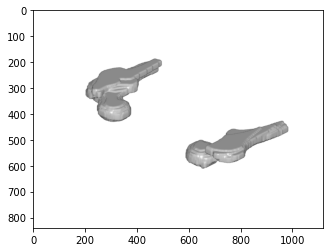

In [51]:
from skimage.io import imread

img = imread('mask/patient05/test.tif')
print(img.shape)

plt.imshow(img)

Slice Thickness: 4 mm 
Pixel Spacing (row, col): (0.91145831346512, 0.91145831346512)

In [6]:
from pydicom import dcmread
import numpy as np
dir = 'data/images/images_01/1-01.dcm'
ds = dcmread(dir)
print(f'Slice Thickness: {ds.SliceThickness}')
print(f'Pixel Spacing (row, col): ({ds.PixelSpacing[0]}, {ds.PixelSpacing[1]})')

Slice Thickness: 4
Pixel Spacing (row, col): (0.91145831346512, 0.91145831346512)


In [7]:
np.array([float(ds.SliceThickness), float(ds.PixelSpacing[0]), float(ds.PixelSpacing[0])])

array([4.        , 0.91145831, 0.91145831])

In [33]:
pip install plotly==5.9.0

  Using cached plotly-5.9.0-py2.py3-none-any.whl (15.2 MB)
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [52]:
# %reload_ext signature
# %matplotlib inline

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
import scipy.ndimage as ndimage
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

file_used= 'test_data.npy'
imgs_to_process = np.load(file_used).astype(np.float64)

def resample(image, new_spacing=[1,1,1]):
    spacing = np.array([float(ds.SliceThickness), 
                        float(ds.PixelSpacing[0]), 
                        float(ds.PixelSpacing[0])])

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print(f'Shape before resampling: {imgs_to_process.shape}')
imgs_after_resamp, spacing = resample(imgs_to_process, [1,1,1])
print(f'Shape after resampling: {imgs_after_resamp.shape}')

Shape before resampling: (35, 224, 224)
Shape after resampling: (140, 204, 204)


In [48]:
def make_mesh(image, threshold=0.5, step_size=1):

    print("Transposing surface")
    p = image.transpose(2,1,0)
    print(p.max())
    print(p.min())
    p = ndimage.uniform_filter(p, 5)
    
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True)
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = ff.create_trisurf(x=x, y=y, z=z, plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)
    return fig

def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
#     ax.set_axis_bgcolor((0.7, 0.7, 0.7))
    ax.set_facecolor((0.7,0.7,0.7))
    plt.show()

Transposing surface
1.5285343669360156
-0.4034707270914223
Calculating surface
Drawing


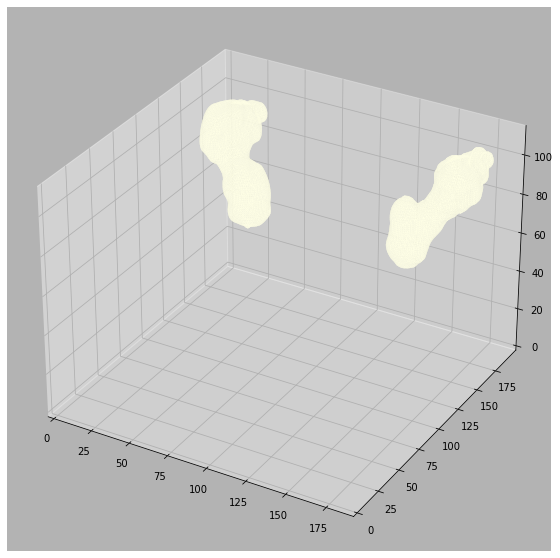

Drawing


In [49]:
v, f = make_mesh(imgs_after_resamp, threshold = 0.5) #350 previously default value
plt_3d(v, f)
fig = plotly_3d(v, f)

In [45]:
pip install dash

     |████████████████████████████████| 9.8 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 421 kB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [50]:
from dash import dcc

In [51]:
dcc.Graph(figure=fig)

Graph(figure=Figure({
    'data': [{'facecolor': array(['rgb(236, 236, 212)', 'rgb(236, 236, 212)', 'rgb(236, 236, 212)', ...,
                                  'rgb(236, 236, 212)', 'rgb(236, 236, 212)', 'rgb(236, 236, 212)'],
                                 dtype=object),
              'i': array([    2,     4,     0, ..., 21125, 21127, 21127], dtype=int32),
              'j': array([    1,     3,     3, ..., 21202, 21202, 21203], dtype=int32),
              'k': array([    0,     0,     2, ..., 21127, 21203, 21114], dtype=int32),
              'name': '',
              'type': 'mesh3d',
              'x': [13.986026763916016, 14.0, 14.0, ..., 187.39866638183594,
                    187.25112915039062, 187.00152587890625],
              'y': [146.0, 146.0, 145.92750549316406, ..., 156.0, 156.0, 156.0],
              'z': [91.0, 90.95414733886719, 91.0, ..., 97.0, 98.0, 99.0]},
             {'hoverinfo': 'none',
              'marker': {'color': [55.477055, 112.44245],
              